# **Part - I : Classification of Food Course Type**

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
import collections
import warnings
warnings.filterwarnings("ignore")
 
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


**Preliminary Understanding of Data and Data Preprocessing and Cleaning**

In [2]:
# Basis information of dataset provided
data=pd.read_csv("Data.csv") 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              255 non-null    object 
 1   Ingradients       255 non-null    object 
 2   Diet              255 non-null    object 
 3   Preparation Time  225 non-null    float64
 4   Cooking Time      227 non-null    float64
 5   Flavor            226 non-null    object 
 6   Course            255 non-null    object 
 7   State             231 non-null    object 
 8   Region            241 non-null    object 
 9   Price/unit        255 non-null    int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 20.0+ KB


In [3]:
# Dropping all rows with NaN will result in loss of almost 30% of the data present (180/225 *100 % data is left)
# Since many features have no NaNs, we will try to retrieve rows with NaNs through various imputations
data.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 253
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              180 non-null    object 
 1   Ingradients       180 non-null    object 
 2   Diet              180 non-null    object 
 3   Preparation Time  180 non-null    float64
 4   Cooking Time      180 non-null    float64
 5   Flavor            180 non-null    object 
 6   Course            180 non-null    object 
 7   State             180 non-null    object 
 8   Region            180 non-null    object 
 9   Price/unit        180 non-null    int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 15.5+ KB


In [4]:
# Elementary Cleaning before filling NaNs

data=data.drop(columns=['Name','State'])

# Dropping State because we already have a Region feature present which has the states aggregated in groups 
# Moreover after encoding of categorical variables using State would unnecessarily result in large number of columns 

data=data.rename(columns={'Ingradients':'Ingredients'})  # Correcting Ingradients to Ingredients

In [5]:
# Filling NaNs of Prep and Cook Time
# For doing this we try finding its correlation with Price/Unit (since it is ony numerical feature present) and 

# finding its mean/median when grouping with region/ flavor/ diet
# But again flavor has many NaNs and considering the imputed values will bring more randomness to imputation of prep/cook time
# and we also reason that total time taken for a dish should be uncorrelated to flavor
 
test=data.dropna(subset=["Cooking Time","Preparation Time"])
test.corr()

Preparation Time  Cooking Time  Price/unit
Preparation Time           1.00000      0.110780   -0.038180
Cooking Time               0.11078      1.000000   -0.000187
Price/unit                -0.03818     -0.000187    1.000000

In [6]:
# We find that price is in fact slightly negatively correlated to prep/cook time. We will discard price for imputation 

# Trying for Diet
data[['Preparation Time','Cooking Time','Diet']].groupby(['Diet'], as_index=False).mean()

# Clearly non-vegetarian food on average takes more time to prepare(due to long hours of marination)
# and cook (because ambient internal temperature has to be maintained to kill bacteria present in raw flesh)

Diet  Preparation Time  Cooking Time
0  non vegetarian         41.842105       40.0000
1      vegetarian         34.791262       38.8125

In [7]:
data[['Preparation Time', 'Cooking Time','Region']].groupby(['Region'], as_index=False).mean()

Region  Preparation Time  Cooking Time
0     Central         13.333333     48.333333
1        East         43.518519     41.607143
2       North         38.020833     41.979167
3  North East         28.846154     28.461538
4       South         58.181818     36.909091
5        West         16.924242     41.880597

In [8]:
data[['Preparation Time','Cooking Time', 'Diet','Region']].groupby(['Diet','Region'], as_index=False).median()

Diet      Region  Preparation Time  Cooking Time
0   non vegetarian        East              12.5          37.5
1   non vegetarian       North             120.0          35.0
2   non vegetarian  North East              10.0          22.5
3   non vegetarian       South              10.0          60.0
4   non vegetarian        West              10.0          40.0
5       vegetarian     Central              10.0          45.0
6       vegetarian        East              20.0          42.5
7       vegetarian       North              15.0          40.0
8       vegetarian  North East              10.0          30.0
9       vegetarian       South              10.0          30.0
10      vegetarian        West              10.0          30.0

In [9]:
data=data.dropna(subset=['Region'])
# Now, we dropna of Region before filling NaNs
# Doing this we lose 14 rows out of 225 rows. Hence, a loss of ~6 percent of data
# Great work in reducing the data loss from 30 percent to 6 percent!!

data=data.reset_index(drop=True)

In [10]:
# Finally filling NaNs of Prep and Cook Time with the median after grouping by diet and region

data['Preparation Time']=data['Preparation Time'].fillna(data.groupby(['Diet','Region'])['Preparation Time'].transform('median'))
data['Cooking Time']=data['Cooking Time'].fillna(data.groupby(['Diet','Region'])['Cooking Time'].transform('median'))

In [11]:
# Now,we will try to fill Nans of Flavor
data["Flavor"].isna().sum()

27

In [12]:
# Notice that sour and bitter have almost negligible appearance in the dataset, which is heavily dominated by spicy 
data["Flavor"].value_counts().sort_values(ascending=True)

sour        1
bitter      4
sweet      82
spicy     127
Name: Flavor, dtype: int64

In [13]:
# In the following function, we will uniformly randomly fill Flavor NaNs from a list 
# that emulates the frequencies of the categorical variables of Flavor
def fill_freq(freq):
  dct={}
  lst=[]
  curr=0
  for idx,flav in enumerate(freq.index):
    dct[curr]=flav
    ct=freq[idx]
    lst=lst+[curr]*ct
    curr+=1
  rnd.shuffle(lst)
  return [dct,lst]

pair=fill_freq(data['Flavor'].value_counts().sort_values(ascending=True))

for idx,x in enumerate(data["Flavor"].isna()):
  if(x):
    temp=pair[1][rnd.randint(0,len(pair[1])-1)]
    data['Flavor'][idx]=pair[0][temp]

In [14]:
# We get a dataset with minimal losses retaining 241 of 255 rows !!
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ingredients       241 non-null    object 
 1   Diet              241 non-null    object 
 2   Preparation Time  241 non-null    float64
 3   Cooking Time      241 non-null    float64
 4   Flavor            241 non-null    object 
 5   Course            241 non-null    object 
 6   Region            241 non-null    object 
 7   Price/unit        241 non-null    int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 15.2+ KB


In [15]:
data["Total"]=data["Preparation Time"]+data["Cooking Time"]

In [16]:
data[['Total', 'Course']].groupby(['Course'], as_index=False).mean().sort_values(by="Total")

Course       Total
1  main course   61.880000
0      dessert   76.829114
2        snack   90.600000
3      starter  217.500000

In [17]:
# Spilling strings in Ingredients column into individual string which will be merged to the dataframe 
# after One Hot encoding and performing PCA on the set of ingredients

ing_dic = collections.defaultdict(int)
food=data
for f in food.index:
    ing_list = food.at[f, 'Ingredients'].split(', ')
    for i in ing_list:
        i = i.lower().strip()
        ing_dic[i] += 1

ing_df = pd.DataFrame.from_dict(ing_dic, orient='index')\
    .rename(columns={0:'count'})

In [18]:
# We find a total of 352 ingredients
ing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 352 entries, maida flour to ginger powder
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   352 non-null    int64
dtypes: int64(1)
memory usage: 5.5+ KB


In [19]:
# But we notice that same ingredients are present with a variety of names in the list of ingredients found

ing_df.sort_index().loc['red': 'red0'].T
# ing_df.sort_index()

red chili  red chilli  red chillies  red food coloring  \
count          1           4             1                  1   

       red kidney beans  red onion  
count                 2          3

In [20]:
# Our strategy will be to perform a string matching algortirhm like SOUNDEX or Fuzzy matching 
# on the list of ingredients to find the common ingredients with different names

# Here, we move forward with Fuzzy matching because according to Wikipedia Fuzzy matching achieves higher benchmarks
# For this purpose we will be using the FuzzyWuzzy library 


similar={}
ing_list = ing_df.sort_values('count').index.to_list()
n = 0
for i in range(len(ing_list)-1):
    for j in range(i+1, len(ing_list)):
        ratio = fuzz.ratio(ing_list[i], ing_list[j])
        # if n == 30:
        #     break
        if ratio >=66:
            # print(ing_list[i], ', ', ing_list[j], '\t', ratio)
            similar[ing_list[i]]=ing_list[j]
            n += 1

In [21]:
# On setting a threshold of 0.66, we found a large dict of matches according to our strategy
# Obviously we would have to now apply our domain knowledge in Indian food to separate the 
# True positives from the below list

similar={
  # 'almond': 'lemon',
  # 'almonds': 'lemon',
  # 'alum powder': 'chili powder',
  # 'amaranth leaves': 'methi leaves',
  # 'amchur powder': 'chili powder',
  # 'arhar dal': 'chana dal',
  # 'atta': 'sattu',
  'baby potatoes': 'potatoes',
  # 'baingan': 'baking soda',
  # 'baking powder': 'baking soda',
  # 'banana flower': 'besan flour',
  # 'beans': 'besan',
  'beaten rice flakes': 'rice flakes',
  # 'bell pepper': 'black pepper',
  # 'bell peppers': 'black pepper',
  'bengal gram flour': 'gram flour',
  # 'besan flour': 'rice flour',
  'biryani masala': 'garam masala',
  'biryani masala powder': 'garam masala powder',
  # 'bitter gourd': 'bottle gourd',
  # 'black lentils': 'black salt',
  'black sesame seeds': 'sesame seeds',
  # 'blend rice': 'lemon juice',
  'boiled potatoes': 'potatoes',
  'brown rice': 'raw rice',
  # 'brown rice flour': 'rice flour',
  # 'canned coconut milk': 'grated coconut',
  'cardamom pods': 'cardamom',
  # 'cardamom powder': 'garam masala powder',
  'carrots': 'carrot',
  'cashews': 'cashew nuts',
  'chana daal': 'chana dal',
  'chenna': 'chhena',
  'chenna cheese': 'cottage cheese',
  'chicken chunks': 'chicken',
  'chicken thighs': 'chicken',
  # 'chickpea flour': 'rice flour',
  # 'chickpeas': 'chicken',
  'chilli': 'chillies',
  'chillies': 'green chilies',
  'cinnamon stick': 'cinnamon',
  'coconut flakes': 'coconut',
  # 'coconut ice': 'coconut',
  # 'coconut milk': 'coconut',
  # 'coconut oil': 'coconut',
  # 'corn flour': 'rice flour',
  'dates': 'dry dates',
  'desiccated coconut': 'grated coconut',
  'drumstick': 'drumsticks',
  'dry chilli': 'chillies',
  'dry coconut': 'coconut',
  'dry dates': 'dry roasted',
  'fennel': 'fennel seeds',
  # 'fennel seeds': 'sesame seeds',
  # 'fenugreek seeds': 'fennel seeds',
  'fish fillets': 'fish fillet',
  # 'fish roe': 'fish',
  # 'flour': 'rice flour',
  'fresh coconut': 'coconut',
  'fresh green chilli': 'green chilies',
  'fresh green peas': 'green peas',
  'fried milk power': 'milk powder',
  'frozen green peas': 'green peas',
  'garam masala powder': 'garam masala',
  # 'garlic powder': 'garam masala powder',
  # 'ginger powder': 'milk powder',
  # 'gram flour': 'rice flour',
  'grated coconut': 'coconut',
  # 'gravy': 'rava',
  'greek yogurt': 'yogurt',
  # 'green': 'ghee',
  # 'green beans': 'green chilies',
  'green bell pepper': 'bell pepper',
  'green cardamom': 'cardamom',
  'green chili': 'green chilies',
  'green chili paste': 'green chilies',
  'green chilli': 'green chilies',
  'green chillies': 'green chilies',
  # 'green moong beans': 'green peas',
  # 'green peas': 'green chilies',
  # 'greens': 'green peas',
  # 'gur': 'yogurt',
  'jaggery syrup': 'jaggery',
  # 'jowar flour': 'rice flour',
  # 'kala masala': 'garam masala',
  # 'lentil flour': 'wheat flour',
  'lentils': 'black lentils',
  'long beans': 'beans',
  # 'maida flour': 'rice flour',
  # 'malai': 'imli',
  # 'malvani masala': 'pav bhaji masala',
  # 'marinade': 'tamarind',
  'masala': 'garam masala',
  # 'masoor dal': 'moong dal',
  # 'mawa': 'maida',
  # 'meat curry powder': 'sambar powder',
  # 'milk powder': 'chili powder',
  'moong beans': 'moong dal',
  'mung bean': 'moong beans',
  'mushroom': 'wild mushrooms',
  'mustard': 'mustard oil',
  # 'mustard green': 'mustard oil',
  # 'mustard seed': 'mustard oil',
  # 'mustard seeds': 'mustard oil',
  # 'naan bread': 'loaf bread',
  # 'nigella seeds': 'fennel seeds',
  # 'onions': 'red onion',
  'peanut': 'peanuts',
  # 'peanut oil': 'coconut oil',
  # 'peanuts': 'nuts',
  # 'pearl onions': 'red onion',
  # 'peas': 'beans',
  # 'pigeon peas': 'green peas',
  # 'plain flour': 'rice flour',
  # 'potato': 'tomato',
  'potatoes': 'potato',
  # 'potol': 'potato',
  'raw banana': 'banana',
  'raw peanuts': 'peanuts',
  'raw rice': 'rice',
  'red chili': 'green chilies',
  'red chilli': 'green chilies',
  'red chillies': 'green chilies',
  # 'refined flour': 'rice flour',
  # 'rice flakes': 'rice flour',
  # 'ridge gourd': 'rice flour',
  'roasted gram flour': 'gram flour',
  # 'rock salt': 'black salt',
  # 'rose water': 'hot water',
  # 'sattu': 'salt',
  'sesame': 'sesame seeds',
  # 'sevai': 'sev',
  'skimmed milk powder': 'milk powder',
  'sliced almonds': 'almonds',
  # 'soaked rice': 'cooked rice',
  # 'sorghum flour': 'gram flour',
  'split pigeon peas': 'pigeon peas',
  'split urad dal': 'urad dal',
  # 'steamer': 'sesame',
  # 'sticky rice': 'basmati rice',
  # 'sweet potato': 'potato',
  'tamarind paste': 'tamarind',
  # 'tandoori masala': 'garam masala',
  # 'tea bags': 'tea leaves',
  # 'tea leaves': 'methi leaves',
  'thin rice flakes': 'rice flakes',
  # 'tomato paste': 'tomato',
  # 'tomato sauce': 'tomato',
  'tomatoes': 'tomato',
  # 'toor dal': 'moong dal',
  'vinegar': 'wine vinegar',
  'water': 'hot water',
  # 'wheat flour': 'rice flour',
  # 'white bread slices': 'white sesame seeds',
  # 'white flour': 'rice flour',
  'white sesame seeds': 'sesame seeds',
  'white urad dal': 'urad dal',
  # 'whole egg': 'whole red',
  'whole red beans': 'whole red',
  'whole urad dal': 'urad dal',
  # 'whole wheat bread': 'whole wheat flour',
  'whole wheat flour': 'wheat flour',
  # 'whole wheat rava': 'whole wheat flour',
  'yellow moong daal': 'moong dal',
  'yellow mustard': 'mustard',
  'yoghurt': 'yogurt'
}

In [22]:
# This is the final dict after filtering the above dict
# We have also hard-coded some translations of Hindi-English ingredients 
# which our Fuzzy algorithm couldn't find

similar_new={
  'baby potatoes': 'potatoes',
  'beaten rice flakes': 'rice flakes',
  'bengal gram flour': 'gram flour',
  'biryani masala': 'garam masala',
  'biryani masala powder': 'garam masala',
  'black sesame seeds': 'sesame seeds',
  'boiled potatoes': 'potatoes',
  'cardamom pods': 'cardamom',
  'carrots': 'carrot',
  'cashews': 'cashew nuts',
  'chana daal': 'chana dal',
  'chenna': 'chhena',
  'chenna cheese': 'cottage cheese',
  'chicken chunks': 'chicken',
  'chicken thighs': 'chicken',
  'chilli': 'green chillies',
  'chillies': 'green chillies',
  'cinnamon stick': 'cinnamon',
  'coconut flakes': 'coconut',
  'dry dates': 'dates',
  'desiccated coconut': 'grated coconut',
  'drumstick': 'drumsticks',
  'dry chilli': 'green chillies',
  'dry coconut': 'coconut',
  'dry roasted': 'dates',
  'fennel': 'fennel seeds',
  'fish fillets': 'fish fillet',
  'fresh coconut': 'coconut',
  'fresh green chilli': 'green chillies',
  'fresh green peas': 'green peas',
  'fried milk power': 'milk powder',
  'frozen green peas': 'green peas',
  'garam masala powder': 'garam masala',
  'grated coconut': 'coconut',
  'greek yogurt': 'yogurt',
  'green bell pepper': 'bell pepper',
  'red bell pepper': 'bell pepper',
  'yellow bell pepper': 'bell pepper',
  'green cardamom': 'cardamom',
  'green chili': 'green chillies',
  'green chili paste': 'green chillies',
  'green chilli': 'green chillies',
  'green chilies': 'green chillies',

  'gur' : 'jaggery',
  'jaggery syrup': 'jaggery',
  'lentils': 'black lentils',
  'long beans': 'beans',
  'masala': 'garam masala',
  'moong beans': 'moong dal',
  'mung bean': 'moong dal',
  'mushroom': 'wild mushrooms',
  'mustard': 'mustard oil',
  'peanut': 'peanuts',
  'potato': 'potatoes',
  'raw banana': 'banana',
  'raw peanuts': 'peanuts',
  'raw rice': 'rice',

  'red chili': 'red chillies',
  'red chilli': 'red chillies',

  'roasted gram flour': 'gram flour',
  'sesame': 'sesame seeds',
  'skimmed milk powder': 'milk powder',
  'sliced almonds': 'almonds',
  'split pigeon peas': 'pigeon peas',
  'split urad dal': 'urad dal',
  'tamarind paste': 'tamarind',
  'thin rice flakes': 'rice flakes',
  'tomato': 'tomatoes',
  'wine vinegar': 'vinegar',
  'hot water': 'water',
  'white sesame seeds': 'sesame seeds',
  'white urad dal': 'urad dal',
  'whole red': 'whole red beans',
  'whole urad dal': 'urad dal',
  'whole wheat flour': 'wheat flour',
  'yellow moong daal': 'moong dal',
  'yellow mustard': 'mustard oil',
  'yoghurt': 'yogurt',
  'dahi': 'yogurt',
  'palak' : 'spinach',
  'aloo' : 'potatoes',
  'badam' : 'peanuts',
  'baingan' : 'eggplant',
  'brinjal' : 'eggplant',
  'tomato sauce' : 'sauce'
}

In [23]:
# Using the above dict to map common ingredients into a new_ingredients_dict

new_ing_dic = collections.defaultdict(int)

for f in food.index:
    tmp_list = food.at[f, 'Ingredients'].split(', ')
    for i in tmp_list:
        i = i.lower().strip()
        if i in similar_new:
            i = similar_new[i]
        new_ing_dic[i] += 1
            
new_ing_df = pd.DataFrame.from_dict(new_ing_dic, orient='index')\
    .rename(columns={0:'count'})
new_ing_df.sort_index().loc['red':'red0'].T

red chillies  red food coloring  red kidney beans  red onion
count             6                  1                 2          3

In [24]:
BoI_df = pd.DataFrame(
    np.zeros(len(food)*len(new_ing_dic)).reshape(len(food),len(new_ing_dic))\
    .astype(int),index=food.index, columns=new_ing_df.index)

for f in food.index:
    tmp_list = food.at[f, 'Ingredients'].split(', ')
    for i in tmp_list:
        i = i.lower()
        if i[0] == ' ':
            i = i[1:]
        if i[-1] ==' ':
            i = i[:-1]
        if i in similar:
            i = similar[i]
        BoI_df.at[f, i]=1

In [25]:
# Our string matching routine has reduced the ingredients size form 350s to 240s
# heavily bringing down the redudancy
BoI_df=BoI_df.dropna(axis=1)
BoI_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Columns: 270 entries, maida flour to ginger powder
dtypes: int64(270)
memory usage: 508.5 KB


In [26]:
# Bag of Ingredients

BoI_df.head()

maida flour  yogurt  oil  sugar  gram flour  ghee  carrot  milk  \
0            1       1    1      1           0     0       0     0   
1            0       0    0      1           1     1       0     0   
2            0       0    0      1           0     1       1     1   
3            0       0    0      1           0     1       0     1   
4            0       0    0      1           0     1       0     1   

   cashew nuts  raisins  flour  kewra  clarified butter  almonds  pistachio  \
0            0        0      0      0                 0        0          0   
1            0        0      0      0                 0        0          0   
2            1        1      0      0                 0        0          0   
3            0        0      1      1                 1        1          1   
4            0        0      0      0                 0        0          0   

   saffron  cardamom  milk powder  plain flour  baking powder  water  \
0        0         0            0            0              0      0   
1        0         0            0            0              0      0   
2        0         0            0            0              0      0   
3        1         1            0            0              0      0   
4        0         0            1            1              1      0   

   rose water  sugar syrup  lentil flour  maida  corn flour  baking soda  \
0           0            0             0      0           0            0   
1           0            0             0      0           0            0   
2           0            0             0      0           0            0   
3           0            0             0      0           0            0   
4           1            0             0      0           0            0   

   vinegar  curd  turmeric  cottage cheese  nuts  firm white pumpkin  \
0        0     0         0               0     0                   0   
1        0     0         0               0     0                   0   
2        0     0         0               0     0                   0   
3        0     0         0               0     0                   0   
4        0     0         0               0     0                   0   

   kitchen lime  alum powder  rice  condensed milk  spices  semolina  khoa  \
0             0            0     0               0       0         0     0   
1             0            0     0               0       0         0     0   
2             0            0     0               0       0         0     0   
3             0            0     0               0       0         0     0   
4             0            0     0               0       0         0     0   

   coconut  molu leaf  dry fruits  chhena  cream  lemon juice  refined flour  \
0        0          0           0       0      0            0              0   
1        0          0           0       0      0            0              0   
2        0          0           0       0      0            0              0   
3        0          0           0       0      0            0              0   
4        0          0           0       0      0            0              0   

   fennel seeds  besan flour  jaggery  rice flour  wheat flour  \
0             0            0        0           0            0   
1             0            0        0           0            0   
2             0            0        0           0            0   
3             0            0        0           0            0   
4             0            0        0           0            0   

   sweetened milk  reduced milk  vegetable oil  elachi  besan  \
0               0             0              0       0      0   
1               0             0              0       0      0   
2               0             0              0       0      0   
3               0             0              0       0      0   
4               0             0              0       0      0   

   cardamom powder  cashews and raisins  peanu

In [27]:
# Performing PCA on the bag of ingredients for better feature selection

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

pca = PCA(0.90)
pca = pca.fit(BoI_df)
pca.n_components_

99

In [28]:
ing_column_names = []
for i in range(np.shape(pca.transform(BoI_df))[1]):
  ing_column_names.append('ing'+ str(i))



In [29]:
tempdf = pd.DataFrame(pca.transform(BoI_df), columns = ing_column_names)
data.shape

(241, 9)

In [30]:
final_data = pd.concat([data,tempdf],axis=1)
final_data

Ingredients            Diet  \
0                      Maida flour, yogurt, oil, sugar      vegetarian   
1                              Gram flour, ghee, sugar      vegetarian   
2         Carrots, milk, sugar, ghee, cashews, raisins      vegetarian   
3    Flour, ghee, kewra, milk, clarified butter, su...      vegetarian   
4    Milk powder, plain flour, baking powder, ghee,...      vegetarian   
5                            Sugar syrup, lentil flour      vegetarian   
6    Maida, corn flour, baking soda, vinegar, curd,...      vegetarian   
7                          Milk, cottage cheese, sugar      vegetarian   
8                            Yogurt, milk, nuts, sugar      vegetarian   
9    Firm white pumpkin, sugar, kitchen lime, alum ...      vegetarian   
10                                   Rice, sugar, nuts      vegetarian   
11                 Condensed milk, sugar, spices, nuts      vegetarian   
12                          Semolina, ghee, nuts, milk      vegetarian   
13                            Khoa, coconut, molu leaf      vegetarian   
14                        Corn flour, ghee, dry fruits      vegetarian   
15             Gram flour, ghee, sugar, milk, cardamom      vegetarian   
16                                 Chhena, sugar, ghee      vegetarian   
17                                 Chhena, sugar, milk      vegetarian   
18                                Sugar, chenna cheese      vegetarian   
19   Flour, cream, sugar, saffron, lemon juice, coc...      vegetarian   
20    Chenna, condensed milk, sugar, saffron, cardamom      vegetarian   
21                                 Chhena, sugar, ghee      vegetarian   
22                Flour, fried milk power, sugar syrup      vegetarian   
23          Yoghurt, refined flour, ghee, fennel seeds      vegetarian   
24                            Besan flour, sugar, ghee      vegetarian   
25                                       Milk, jaggery      vegetarian   
26                          Chhena, sugar, ghee, flour      vegetarian   
27                             Rice flour, wheat flour      vegetarian   
28                              Chenna, sweetened milk      vegetarian   
29                     Chhena, reduced milk, pistachio      vegetarian   
30                             Chhena, sugar, cardamom      vegetarian   
31                      Milk, sugar, saffron, cardamom      vegetarian   
32    Rice flour, jaggery, ghee, vegetable oil, elachi      vegetarian   
33                           Rice flour, jaggery, ghee      vegetarian   
34   Besan, jaggery, cardamom powder, ghee, cashews...      vegetarian   
35                                    Peanuts, jaggery      vegetarian   
36                  Milk, Sugar, Dharwadi buffalo milk      vegetarian   
37                                    Loaf bread, milk      vegetarian   
38             Rice flour, sugar, salt, ghee, semolina      vegetarian   
39                                  Wheat flour, sugar      vegetarian   
40                                 Black lentils, rice      vegetarian   
41   Besan flour, semolina, mung bean, jaggery, coc...      vegetarian   
42   Maida flour, turmeric, coconut, chickpeas, jag...      vegetarian   
43                                    Rice flour, milk      vegetarian   
44                                  Chana dal, jaggery      vegetarian   
45                        Rice, jaggery, cashews, ghee      vegetarian   
46                    Rice flour, powdered sugar, ghee      vegetarian   
47                               Apricots, sugar syrup      vegetarian   
48                            Vermicelli pudding, milk      vegetarian   
49                Rice flour, banana, jaggery, coconut      vegetarian   
50                        Rice flour, jaggery, coconut      vegetarian   
51                Rice flour, jaggery, khus-khus seeds      vegetarian   
52                                   Sugar, milk, nuts      vegetarian   
53                                      Cucumbe

In [31]:
final_data.shape

(241, 108)

In [32]:
pakka_final_data=final_data.drop(columns=["Ingredients"])

In [33]:
pakka_final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Columns: 107 entries, Diet to ing98
dtypes: float64(102), int64(1), object(4)
memory usage: 201.6+ KB


In [34]:
df = pakka_final_data.copy()

In [35]:
df.head()

Diet  Preparation Time  Cooking Time Flavor   Course Region  \
0  vegetarian              45.0          25.0  sweet  dessert   East   
1  vegetarian              80.0          30.0  sweet  dessert   West   
2  vegetarian              15.0          60.0  sweet  dessert  North   
3  vegetarian              15.0          30.0  sweet  dessert   West   
4  vegetarian              15.0          40.0  sweet  dessert   East   

   Price/unit  Total      ing0      ing1      ing2      ing3      ing4  \
0         260   70.0  0.638262 -0.214640  0.153183  0.055685 -0.095383   
1         270  110.0  0.881877 -0.151533  0.030913  0.303766 -0.243389   
2         450   75.0  1.284324 -0.509263  0.256137 -0.073878  0.241311   
3         460   45.0  1.687540 -0.511026  0.349767  0.171247  0.058408   
4         300   55.0  1.339249 -0.369189  0.226180  0.001485  0.036164   

       ing5      ing6      ing7      ing8      ing9     ing10     ing11  \
0  0.109502  0.056338 -0.172120 -0.045739 -0.291777 -0.401254 -0.190111   
1  0.446090 -0.190131  0.681535  0.232293 -0.177573 -0.453553  0.196953   
2  0.064336 -0.105748  0.199021 -0.023972  0.493316 -0.455705 -0.131237   
3  0.131535 -0.117514  0.066387 -0.008135  0.163714  0.875769  0.880653   
4  0.058416 -0.153069  0.379087  0.193676  0.240415 -0.175163 -0.068755   

      ing12     ing13     ing14     ing15     ing16     ing17     ing18  \
0  0.325834 -0.665878  0.152685 -0.103096  0.589214  0.068718  0.027374   
1  0.019965 -0.045817 -0.155692 -0.094780 -0.148790 -0.200539 -0.129675   
2 -0.225831  0.483020  0.319040 -0.130005 -0.234901  0.183425  0.260781   
3  0.522569  0.909907  0.512765  0.631619  0.265113 -0.056764 -0.128931   
4 -0.066537  0.213048  0.287509  0.645319 -0.279181  0.025023  0.475251   

      ing19     ing20     ing21     ing22     ing23     ing24     ing25  \
0 -0.158451 -0.091949 -0.109814 -0.100765  0.090086 -0.132264 -0.256061   
1  0.133476  0.200948  0.048094  0.009741  0.073621  0.086193  0.022871   
2  0.499051  0.095162  0.540733 -0.015536 -0.187604  0.506257 -0.398080   
3 -0.054555 -0.210422 -0.229879  0.194242  0.259898  0.183209  0.108469   
4  0.172541 -0.003310  0.137398  0.112972 -0.168448 -0.253074 -0.020511   

      ing26     ing27     ing28     ing29     ing30     ing31     ing32  \
0 -0.251836  0.061117  0.085380  0.203848 -0.122534  0.002543 -0.148836   
1  0.034778  0.031636 -0.046646 -0.059543 -0.068608 -0.033690  0.110615   
2 -0.113124  0.081358  0.051172 -0.253062 -0.375070  0.114482 -0.151100   
3 -0.394997  0.038273 -0.528973 -0.179255 -0.336710  0.226097 -0.043067   
4  0.313288 -0.117297 -0.154472 -0.078339 -0.248462  0.024267  0.276870   

      ing33     ing34     ing35     ing36     ing37     ing38     ing39  \
0  0.150874 -0.015653  0.097574  0.086173  0.237091  0.121351  0.008438   
1  0.054953  0.011730 -0.046603 -0.037033 -0.022259 -0.015880 -0.065793   
2 -0.026684 -0.435271  0.160915 -0.258727  0.062935  0.204997  0.203494   
3 -0.186019  0.236464 -0.200378  0.099906  0.089467  0.016693 -0.177384   
4 -0.152716  0.796444  0.390161  0.139504  0.054825  0.021457  0.317878   

      ing40     ing41     ing42     ing43     ing44     ing45     ing46  \
0  0.095851 -0.091992  0.015456 -0.002107  0.046461  0.171435  0.026029   
1 -0.074958 -0.044879 -0.206343  0.082325  0.107145 -0.060108 -0.020059   
2  0.300927 -0.222635 -0.029380 -0.024700 -0.109397  0.061773 -0.013300   
3 -0.219394 -0.229803 -0.063303 -0.054017 -0.074842 -0.378132 -0.132878   
4  0.256998  0.384468  0.022148  0.060141  0.699756  0.623130 -0.042418   

      ing47     ing48     ing49     ing50     ing51     ing52     ing53  \
0 -0.168113 -0.126655  0.086241  0.041887  0.264038 -0.247458 -0.122325   
1 -0.034177 -0.055133  0.005742 -0.062372 -0.014028 -0.051468 -0.060694   
2 -0.183628  0.045600  0.012343 -0.009856 -0.003939 -0.101397  0.014895   
3 -0.073071  0.049145  0.358076  0.033198  0.274765  0.086178  0.161975   
4  0.054619 -0.001780 -0.411904  0.079452 -0.07027

In [36]:
# unique values in attribute Course

pd.unique(df['Course'])

array(['dessert', 'main course', 'starter', 'snack'], dtype=object)

In [37]:
# Creating the dependent variable class and Converting all string categoricals to numerical categoricals 
factor = pd.factorize(df['Course'])
df.Course = factor[0]
definitions = factor[1]
print(df.Course.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: Course, dtype: int64
Index(['dessert', 'main course', 'starter', 'snack'], dtype='object')


In [38]:
df.head()  # obtaining - 0 : dessert, 1 : main course, 2 : starter, 3 : snack

Diet  Preparation Time  Cooking Time Flavor  Course Region  \
0  vegetarian              45.0          25.0  sweet       0   East   
1  vegetarian              80.0          30.0  sweet       0   West   
2  vegetarian              15.0          60.0  sweet       0  North   
3  vegetarian              15.0          30.0  sweet       0   West   
4  vegetarian              15.0          40.0  sweet       0   East   

   Price/unit  Total      ing0      ing1      ing2      ing3      ing4  \
0         260   70.0  0.638262 -0.214640  0.153183  0.055685 -0.095383   
1         270  110.0  0.881877 -0.151533  0.030913  0.303766 -0.243389   
2         450   75.0  1.284324 -0.509263  0.256137 -0.073878  0.241311   
3         460   45.0  1.687540 -0.511026  0.349767  0.171247  0.058408   
4         300   55.0  1.339249 -0.369189  0.226180  0.001485  0.036164   

       ing5      ing6      ing7      ing8      ing9     ing10     ing11  \
0  0.109502  0.056338 -0.172120 -0.045739 -0.291777 -0.401254 -0.190111   
1  0.446090 -0.190131  0.681535  0.232293 -0.177573 -0.453553  0.196953   
2  0.064336 -0.105748  0.199021 -0.023972  0.493316 -0.455705 -0.131237   
3  0.131535 -0.117514  0.066387 -0.008135  0.163714  0.875769  0.880653   
4  0.058416 -0.153069  0.379087  0.193676  0.240415 -0.175163 -0.068755   

      ing12     ing13     ing14     ing15     ing16     ing17     ing18  \
0  0.325834 -0.665878  0.152685 -0.103096  0.589214  0.068718  0.027374   
1  0.019965 -0.045817 -0.155692 -0.094780 -0.148790 -0.200539 -0.129675   
2 -0.225831  0.483020  0.319040 -0.130005 -0.234901  0.183425  0.260781   
3  0.522569  0.909907  0.512765  0.631619  0.265113 -0.056764 -0.128931   
4 -0.066537  0.213048  0.287509  0.645319 -0.279181  0.025023  0.475251   

      ing19     ing20     ing21     ing22     ing23     ing24     ing25  \
0 -0.158451 -0.091949 -0.109814 -0.100765  0.090086 -0.132264 -0.256061   
1  0.133476  0.200948  0.048094  0.009741  0.073621  0.086193  0.022871   
2  0.499051  0.095162  0.540733 -0.015536 -0.187604  0.506257 -0.398080   
3 -0.054555 -0.210422 -0.229879  0.194242  0.259898  0.183209  0.108469   
4  0.172541 -0.003310  0.137398  0.112972 -0.168448 -0.253074 -0.020511   

      ing26     ing27     ing28     ing29     ing30     ing31     ing32  \
0 -0.251836  0.061117  0.085380  0.203848 -0.122534  0.002543 -0.148836   
1  0.034778  0.031636 -0.046646 -0.059543 -0.068608 -0.033690  0.110615   
2 -0.113124  0.081358  0.051172 -0.253062 -0.375070  0.114482 -0.151100   
3 -0.394997  0.038273 -0.528973 -0.179255 -0.336710  0.226097 -0.043067   
4  0.313288 -0.117297 -0.154472 -0.078339 -0.248462  0.024267  0.276870   

      ing33     ing34     ing35     ing36     ing37     ing38     ing39  \
0  0.150874 -0.015653  0.097574  0.086173  0.237091  0.121351  0.008438   
1  0.054953  0.011730 -0.046603 -0.037033 -0.022259 -0.015880 -0.065793   
2 -0.026684 -0.435271  0.160915 -0.258727  0.062935  0.204997  0.203494   
3 -0.186019  0.236464 -0.200378  0.099906  0.089467  0.016693 -0.177384   
4 -0.152716  0.796444  0.390161  0.139504  0.054825  0.021457  0.317878   

      ing40     ing41     ing42     ing43     ing44     ing45     ing46  \
0  0.095851 -0.091992  0.015456 -0.002107  0.046461  0.171435  0.026029   
1 -0.074958 -0.044879 -0.206343  0.082325  0.107145 -0.060108 -0.020059   
2  0.300927 -0.222635 -0.029380 -0.024700 -0.109397  0.061773 -0.013300   
3 -0.219394 -0.229803 -0.063303 -0.054017 -0.074842 -0.378132 -0.132878   
4  0.256998  0.384468  0.022148  0.060141  0.699756  0.623130 -0.042418   

      ing47     ing48     ing49     ing50     ing51     ing52     ing53  \
0 -0.168113 -0.126655  0.086241  0.041887  0.264038 -0.247458 -0.122325   
1 -0.034177 -0.055133  0.005742 -0.062372 -0.014028 -0.051468 -0.060694   
2 -0.183628  0.045600  0.012343 -0.009856 -0.003939 -0.101397  0.014895   
3 -0.073071  0.049145  0.358076  0.033198  0.274765  0.086178  0.161975   
4  0.054619 -0.001780 -0.411904  0.079452 -0.070276 -0.1

In [39]:
# Creating our independent dataset for modelling

ax = df.copy()
ax.head()

Diet  Preparation Time  Cooking Time Flavor  Course Region  \
0  vegetarian              45.0          25.0  sweet       0   East   
1  vegetarian              80.0          30.0  sweet       0   West   
2  vegetarian              15.0          60.0  sweet       0  North   
3  vegetarian              15.0          30.0  sweet       0   West   
4  vegetarian              15.0          40.0  sweet       0   East   

   Price/unit  Total      ing0      ing1      ing2      ing3      ing4  \
0         260   70.0  0.638262 -0.214640  0.153183  0.055685 -0.095383   
1         270  110.0  0.881877 -0.151533  0.030913  0.303766 -0.243389   
2         450   75.0  1.284324 -0.509263  0.256137 -0.073878  0.241311   
3         460   45.0  1.687540 -0.511026  0.349767  0.171247  0.058408   
4         300   55.0  1.339249 -0.369189  0.226180  0.001485  0.036164   

       ing5      ing6      ing7      ing8      ing9     ing10     ing11  \
0  0.109502  0.056338 -0.172120 -0.045739 -0.291777 -0.401254 -0.190111   
1  0.446090 -0.190131  0.681535  0.232293 -0.177573 -0.453553  0.196953   
2  0.064336 -0.105748  0.199021 -0.023972  0.493316 -0.455705 -0.131237   
3  0.131535 -0.117514  0.066387 -0.008135  0.163714  0.875769  0.880653   
4  0.058416 -0.153069  0.379087  0.193676  0.240415 -0.175163 -0.068755   

      ing12     ing13     ing14     ing15     ing16     ing17     ing18  \
0  0.325834 -0.665878  0.152685 -0.103096  0.589214  0.068718  0.027374   
1  0.019965 -0.045817 -0.155692 -0.094780 -0.148790 -0.200539 -0.129675   
2 -0.225831  0.483020  0.319040 -0.130005 -0.234901  0.183425  0.260781   
3  0.522569  0.909907  0.512765  0.631619  0.265113 -0.056764 -0.128931   
4 -0.066537  0.213048  0.287509  0.645319 -0.279181  0.025023  0.475251   

      ing19     ing20     ing21     ing22     ing23     ing24     ing25  \
0 -0.158451 -0.091949 -0.109814 -0.100765  0.090086 -0.132264 -0.256061   
1  0.133476  0.200948  0.048094  0.009741  0.073621  0.086193  0.022871   
2  0.499051  0.095162  0.540733 -0.015536 -0.187604  0.506257 -0.398080   
3 -0.054555 -0.210422 -0.229879  0.194242  0.259898  0.183209  0.108469   
4  0.172541 -0.003310  0.137398  0.112972 -0.168448 -0.253074 -0.020511   

      ing26     ing27     ing28     ing29     ing30     ing31     ing32  \
0 -0.251836  0.061117  0.085380  0.203848 -0.122534  0.002543 -0.148836   
1  0.034778  0.031636 -0.046646 -0.059543 -0.068608 -0.033690  0.110615   
2 -0.113124  0.081358  0.051172 -0.253062 -0.375070  0.114482 -0.151100   
3 -0.394997  0.038273 -0.528973 -0.179255 -0.336710  0.226097 -0.043067   
4  0.313288 -0.117297 -0.154472 -0.078339 -0.248462  0.024267  0.276870   

      ing33     ing34     ing35     ing36     ing37     ing38     ing39  \
0  0.150874 -0.015653  0.097574  0.086173  0.237091  0.121351  0.008438   
1  0.054953  0.011730 -0.046603 -0.037033 -0.022259 -0.015880 -0.065793   
2 -0.026684 -0.435271  0.160915 -0.258727  0.062935  0.204997  0.203494   
3 -0.186019  0.236464 -0.200378  0.099906  0.089467  0.016693 -0.177384   
4 -0.152716  0.796444  0.390161  0.139504  0.054825  0.021457  0.317878   

      ing40     ing41     ing42     ing43     ing44     ing45     ing46  \
0  0.095851 -0.091992  0.015456 -0.002107  0.046461  0.171435  0.026029   
1 -0.074958 -0.044879 -0.206343  0.082325  0.107145 -0.060108 -0.020059   
2  0.300927 -0.222635 -0.029380 -0.024700 -0.109397  0.061773 -0.013300   
3 -0.219394 -0.229803 -0.063303 -0.054017 -0.074842 -0.378132 -0.132878   
4  0.256998  0.384468  0.022148  0.060141  0.699756  0.623130 -0.042418   

      ing47     ing48     ing49     ing50     ing51     ing52     ing53  \
0 -0.168113 -0.126655  0.086241  0.041887  0.264038 -0.247458 -0.122325   
1 -0.034177 -0.055133  0.005742 -0.062372 -0.014028 -0.051468 -0.060694   
2 -0.183628  0.045600  0.012343 -0.009856 -0.003939 -0.101397  0.014895   
3 -0.073071  0.049145  0.358076  0.033198  0.274765  0.086178  0.161975   
4  0.054619 -0.001780 -0.411904  0.079452 -0.070276 -0.1

In [40]:
# deleting the 'Course' since we'll be predicting it and it is a dependent variable

del ax['Course']
ax

Diet  Preparation Time  Cooking Time  Flavor      Region  \
0        vegetarian              45.0          25.0   sweet        East   
1        vegetarian              80.0          30.0   sweet        West   
2        vegetarian              15.0          60.0   sweet       North   
3        vegetarian              15.0          30.0   sweet        West   
4        vegetarian              15.0          40.0   sweet        East   
5        vegetarian              10.0          50.0   sweet        East   
6        vegetarian              10.0          50.0   sweet       North   
7        vegetarian              20.0          30.0   sweet        East   
8        vegetarian               5.0           5.0   sweet       North   
9        vegetarian              10.0          30.0   sweet       North   
10       vegetarian              30.0          20.0   sweet        East   
11       vegetarian              10.0          45.0   sweet       North   
12       vegetarian              10.0          25.0   sweet        West   
13       vegetarian              10.0          20.0   sweet       North   
14       vegetarian              10.0          60.0   sweet       North   
15       vegetarian              10.0          60.0   sweet        West   
16       vegetarian              10.0          50.0   sweet        East   
17       vegetarian              20.0          60.0   sweet        East   
18       vegetarian              10.0          45.0   sweet        East   
19       vegetarian              40.0          60.0   sweet        East   
20       vegetarian              25.0          60.0   sweet        East   
21       vegetarian              45.0          45.0   sweet        East   
22       vegetarian              20.0          30.0   sweet  North East   
23       vegetarian              10.0         120.0   sweet       North   
24       vegetarian              15.0          30.0   sweet        East   
25       vegetarian             480.0          30.0   sweet        East   
26       vegetarian              45.0          45.0   sweet        East   
27       vegetarian              15.0          35.0   sweet  North East   
28       vegetarian              15.0          30.0   sweet        East   
29       vegetarian             180.0          60.0   sweet        East   
30       vegetarian              10.0          90.0   sweet        East   
31       vegetarian              30.0          20.0   sweet        East   
32       vegetarian              10.0          50.0   sweet        East   
33       vegetarian              15.0          75.0   sweet       South   
34       vegetarian               5.0          35.0   sweet       South   
35       vegetarian              10.0          20.0   sweet        West   
36       vegetarian              20.0          60.0   sweet       South   
37       vegetarian              20.0          30.0   sweet       South   
38       vegetarian              10.0          30.0   sweet       South   
39       vegetarian              10.0          30.0   sweet       South   
40       vegetarian              10.0          20.0   sweet       South   
41       vegetarian               5.0          20.0   sweet       South   
42       vegetarian             180.0          60.0   sweet       South   
43       vegetarian              10.0          25.0   sweet       South   
44       vegetarian             240.0          60.0   sweet       South   
45       vegetarian               5.0          20.0   sweet       South   
46       vegetarian              10.0          60.0   sweet       South   
47       vegetarian              10.0          20.0   sweet       South   
48       vegetarian              10.0          20.0   sweet       South   
49       vegetarian              10.0          20.0   sweet       South   
50       vegetarian              40.0          15.0   sweet       South   
51       vegetarian              10.0          50.0   sweet        West   
52       vegetarian              10.0   

In [41]:
# Considering Columns with categorical data to do one hot encoding

cat_col = ['Diet', 'Flavor', 'Region']
ax = pd.get_dummies(ax, columns = cat_col)
ax.head()

Preparation Time  Cooking Time  Price/unit  Total      ing0      ing1  \
0              45.0          25.0         260   70.0  0.638262 -0.214640   
1              80.0          30.0         270  110.0  0.881877 -0.151533   
2              15.0          60.0         450   75.0  1.284324 -0.509263   
3              15.0          30.0         460   45.0  1.687540 -0.511026   
4              15.0          40.0         300   55.0  1.339249 -0.369189   

       ing2      ing3      ing4      ing5      ing6      ing7      ing8  \
0  0.153183  0.055685 -0.095383  0.109502  0.056338 -0.172120 -0.045739   
1  0.030913  0.303766 -0.243389  0.446090 -0.190131  0.681535  0.232293   
2  0.256137 -0.073878  0.241311  0.064336 -0.105748  0.199021 -0.023972   
3  0.349767  0.171247  0.058408  0.131535 -0.117514  0.066387 -0.008135   
4  0.226180  0.001485  0.036164  0.058416 -0.153069  0.379087  0.193676   

       ing9     ing10     ing11     ing12     ing13     ing14     ing15  \
0 -0.291777 -0.401254 -0.190111  0.325834 -0.665878  0.152685 -0.103096   
1 -0.177573 -0.453553  0.196953  0.019965 -0.045817 -0.155692 -0.094780   
2  0.493316 -0.455705 -0.131237 -0.225831  0.483020  0.319040 -0.130005   
3  0.163714  0.875769  0.880653  0.522569  0.909907  0.512765  0.631619   
4  0.240415 -0.175163 -0.068755 -0.066537  0.213048  0.287509  0.645319   

      ing16     ing17     ing18     ing19     ing20     ing21     ing22  \
0  0.589214  0.068718  0.027374 -0.158451 -0.091949 -0.109814 -0.100765   
1 -0.148790 -0.200539 -0.129675  0.133476  0.200948  0.048094  0.009741   
2 -0.234901  0.183425  0.260781  0.499051  0.095162  0.540733 -0.015536   
3  0.265113 -0.056764 -0.128931 -0.054555 -0.210422 -0.229879  0.194242   
4 -0.279181  0.025023  0.475251  0.172541 -0.003310  0.137398  0.112972   

      ing23     ing24     ing25     ing26     ing27     ing28     ing29  \
0  0.090086 -0.132264 -0.256061 -0.251836  0.061117  0.085380  0.203848   
1  0.073621  0.086193  0.022871  0.034778  0.031636 -0.046646 -0.059543   
2 -0.187604  0.506257 -0.398080 -0.113124  0.081358  0.051172 -0.253062   
3  0.259898  0.183209  0.108469 -0.394997  0.038273 -0.528973 -0.179255   
4 -0.168448 -0.253074 -0.020511  0.313288 -0.117297 -0.154472 -0.078339   

      ing30     ing31     ing32     ing33     ing34     ing35     ing36  \
0 -0.122534  0.002543 -0.148836  0.150874 -0.015653  0.097574  0.086173   
1 -0.068608 -0.033690  0.110615  0.054953  0.011730 -0.046603 -0.037033   
2 -0.375070  0.114482 -0.151100 -0.026684 -0.435271  0.160915 -0.258727   
3 -0.336710  0.226097 -0.043067 -0.186019  0.236464 -0.200378  0.099906   
4 -0.248462  0.024267  0.276870 -0.152716  0.796444  0.390161  0.139504   

      ing37     ing38     ing39     ing40     ing41     ing42     ing43  \
0  0.237091  0.121351  0.008438  0.095851 -0.091992  0.015456 -0.002107   
1 -0.022259 -0.015880 -0.065793 -0.074958 -0.044879 -0.206343  0.082325   
2  0.062935  0.204997  0.203494  0.300927 -0.222635 -0.029380 -0.024700   
3  0.089467  0.016693 -0.177384 -0.219394 -0.229803 -0.063303 -0.054017   
4  0.054825  0.021457  0.317878  0.256998  0.384468  0.022148  0.060141   

      ing44     ing45     ing46     ing47     ing48     ing49     ing50  \
0  0.046461  0.171435  0.026029 -0.168113 -0.126655  0.086241  0.041887   
1  0.107145 -0.060108 -0.020059 -0.034177 -0.055133  0.005742 -0.062372   
2 -0.109397  0.061773 -0.013300 -0.183628  0.045600  0.012343 -0.009856   
3 -0.074842 -0.378132 -0.132878 -0.073071  0.049145  0.358076  0.033198   
4  0.699756  0.623130 -0.042418  0.054619 -0.001780 -0.411904  0.079452   

      ing51     ing52     ing53     ing54     ing55     ing56     ing57  \
0  0.264038 -0.247458 -0.122325  0.167794  0.082744  0.327911  0.436604   
1 -0.014028 -0.051468 -0.060694  0.057988 -0.003410 -0.028612 -0.003566   
2 -0.003939 -0.101397  0.014895  0.018038  0.028091  0.055590 -0.044323   
3  0.274765  0.086178  0.161975 -0.271053 -0.118060  0.163781 -0.098365   
4 -0.070276 -0

In [42]:
ax.shape

(241, 115)

**Modelling and Analytics- Classification**

In [43]:
# Splitting 20% of dataset to test data and 80% of dataset to train data

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(ax, df['Course'], test_size=0.20, random_state=7, shuffle=True)

In [44]:
# Feature Scaling and Standardizing the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [45]:
# dependent dataset after splitting  

y_train.head()

66     1
180    3
210    1
77     2
96     1
Name: Course, dtype: int64

In [46]:
pd.unique(y_train)

array([1, 3, 2, 0])

1. Random Forest Classifier

In [47]:
# Finding best hyperparameters using Grid Search method for Random Forest to function

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 1)

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(x_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 19.4min finished


In [48]:
bestF.best_params_

{'max_depth': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [49]:
# Fitting and Predicting the model
rfc = RandomForestClassifier(random_state = 1, max_depth = 5, n_estimators = 100, min_samples_split = 2, min_samples_leaf = 1)
                                   
model = rfc.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [50]:
# Evaluation Metrics and Confusion Matrix

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score


print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f1_score(y_test, y_pred, average='micro'))

# We obtain results for labels 0, 1, 3 (dessert, main course, snack) since starter's instances are negligible wrt to others
# Even snack results are 0 due to very less number of snack instances in dataset that too parses on with splitting in training and testing dataset  

[[15  0  0]
 [ 0 27  0]
 [ 1  6  0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.82      1.00      0.90        27
           3       0.00      0.00      0.00         7

    accuracy                           0.86        49
   macro avg       0.59      0.67      0.62        49
weighted avg       0.74      0.86      0.79        49

0.8571428571428571


Overall Accuracy : 0.8571428571428571
Producer Accuracy(Recall) : 0.8571428571428571
User Accuracy (Precision) : 0.8571428571428571
Kappa Coefficient : 0.7299212598425198


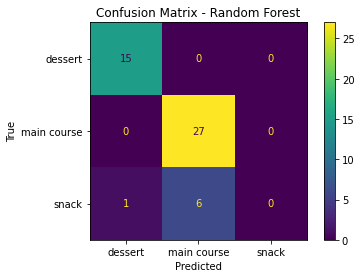

In [130]:
# Proper Confusion Matrix, Overall Accuracy, Kappa Coefficient

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_score,recall_score
cx = confusion_matrix(y_test, y_pred)
cxd = ConfusionMatrixDisplay(cx, display_labels=['dessert', 'main course', 'snack'])
cxd.plot()
cxd.ax_.set(xlabel='Predicted', ylabel='True', title = 'Confusion Matrix - Random Forest')

print('Overall Accuracy :', metrics.accuracy_score(y_test, y_pred))
print('Producer Accuracy(Recall) :', recall_score(y_test, y_pred, average='micro'))
print('User Accuracy (Precision) :', precision_score(y_test, y_pred, average='micro'))
print('Kappa Coefficient :', metrics.cohen_kappa_score(y_test, y_pred, labels=None, weights=None))

In [52]:
# Predicting the Test set results
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
'''
reversefactor = dict(zip(range(4),definitions))
y_test1 = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test1, y_pred, rownames=['Actual'], colnames=['Predicted'])) '''

"\nreversefactor = dict(zip(range(4),definitions))\ny_test1 = np.vectorize(reversefactor.get)(y_test)\ny_pred = np.vectorize(reversefactor.get)(y_pred)\n# Making the Confusion Matrix\nprint(pd.crosstab(y_test1, y_pred, rownames=['Actual'], colnames=['Predicted'])) "

2. Support Vector Machines 

In [53]:
# Linear SVM
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(x_train, y_train)

y_svm1 = svclassifier.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_svm1))
print(classification_report(y_test,y_svm1))
print(f1_score(y_test, y_svm1, average='micro'))

[[15  0  0]
 [ 4 19  4]
 [ 1  3  3]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       0.86      0.70      0.78        27
           3       0.43      0.43      0.43         7

    accuracy                           0.76        49
   macro avg       0.68      0.71      0.69        49
weighted avg       0.77      0.76      0.75        49

0.7551020408163265


In [54]:
# Polynomial kernel
from sklearn.svm import SVC
svclassifier1 = SVC(kernel='poly', degree=8)
svclassifier1.fit(x_train, y_train)

y_svm2 = svclassifier1.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_svm2))
print(classification_report(y_test, y_svm2))
print(f1_score(y_test, y_svm2, average='micro'))

[[ 0 15  0]
 [ 0 27  0]
 [ 0  7  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.55      1.00      0.71        27
           3       0.00      0.00      0.00         7

    accuracy                           0.55        49
   macro avg       0.18      0.33      0.24        49
weighted avg       0.30      0.55      0.39        49

0.5510204081632653


In [55]:
# Gaussian Kernel

from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC

# Finding best hyperparameters for SVM to run

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.513, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.513, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.526, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.513, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.500, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.513, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.513, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.526, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.500, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.500, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.513, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    1.7s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [56]:
grid.best_estimator_

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
svclassifier2 = SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svclassifier2.fit(x_train, y_train)

y_svm3 = svclassifier2.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_svm3))
print(classification_report(y_test, y_svm3))
print(f1_score(y_test, y_svm3, average='micro'))

[[15  0  0]
 [ 3 23  1]
 [ 1  4  2]]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        15
           1       0.85      0.85      0.85        27
           3       0.67      0.29      0.40         7

    accuracy                           0.82        49
   macro avg       0.77      0.71      0.71        49
weighted avg       0.81      0.82      0.80        49

0.8163265306122449


We find that SVM - Gaussian method works best

Overall Accuracy : 0.8163265306122449
Producer Accuracy(Recall) : 0.8163265306122449
User Accuracy (Precision) : 0.8163265306122449
Kappa Coefficient : 0.6771595900439238


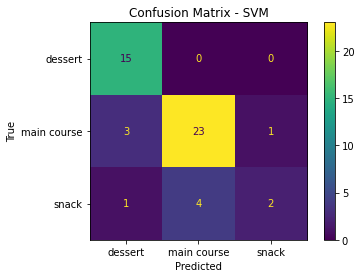

In [129]:
# Proper Confusion Matrix, Overall Accuracy, Kappa Coefficient

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,recall_score,precision_score
c = confusion_matrix(y_test, y_svm3)
cd = ConfusionMatrixDisplay(c, display_labels=['dessert', 'main course', 'snack'])
cd.plot()
cd.ax_.set(xlabel='Predicted', ylabel='True', title = 'Confusion Matrix - SVM')

print('Overall Accuracy :', metrics.accuracy_score(y_test, y_svm3))
print('Producer Accuracy(Recall) :', recall_score(y_test, y_svm3, average='micro'))
print('User Accuracy (Precision) :', precision_score(y_test, y_svm3, average='micro'))
print('Kappa Coefficient :', metrics.cohen_kappa_score(y_test, y_svm3, labels=None, weights=None))

3. Xtreme - Gradient Boosting (XGBOOST)

In [59]:
%%time

# Finding best hyperparameters for XGBoost to run using GridSearch method

import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(x_train, y_train)]
model = xgb.XGBClassifier(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(x_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.001, 'learning_rate': 0.001, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
Best validation score = 0.7970310391363022
CPU times: user 32min 22s, sys: 9.66 s, total: 32min 31s
Wall time: 32min 36s


In [60]:
# Fitting and Predicting model

modelxg = xgb.XGBClassifier(gamma = 0.005, learning_rate = 0.01, max_depth = 10, n_estimators = 400, random_state = 42, objective='reg:squarederror')
modelxg.fit(x_train,y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.005,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [61]:
# Evaluation Metric and Confusion Matrix

y_xg = modelxg.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_xg))
print(classification_report(y_test,y_xg))
print(f1_score(y_test, y_xg, average='micro'))

[[15  0  0]
 [ 0 26  1]
 [ 1  6  0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.81      0.96      0.88        27
           3       0.00      0.00      0.00         7

    accuracy                           0.84        49
   macro avg       0.58      0.65      0.62        49
weighted avg       0.73      0.84      0.78        49

0.8367346938775511


Overall Accuracy : 0.8367346938775511
Producer Accuracy(Recall) : 0.8367346938775511
User Accuracy (Precision) : 0.8367346938775511
Kappa Coefficient : 0.6961240310077519


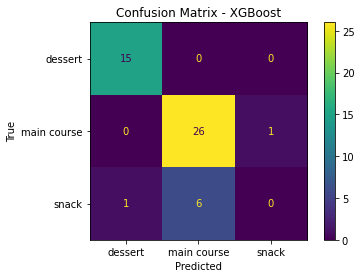

In [128]:
# Proper Confusion Matrix, Overall Accuracy, Kappa Coefficient

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
cm = confusion_matrix(y_test, y_xg)
cmd = ConfusionMatrixDisplay(cm, display_labels=['dessert', 'main course', 'snack'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True', title = 'Confusion Matrix - XGBoost')

print('Overall Accuracy :', metrics.accuracy_score(y_test, y_xg))
print('Producer Accuracy(Recall) :', recall_score(y_test, y_xg, average='micro'))
print('User Accuracy (Precision) :', precision_score(y_test, y_xg, average='micro'))
print('Kappa Coefficient :', metrics.cohen_kappa_score(y_test, y_xg, labels=None, weights=None))

# **Part - II : Classifaction of Flavor**

**Understanding Preliminary Data and Data Preprocessing and Cleaning**

In [63]:
data1=pd.read_csv("Data.csv")
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              255 non-null    object 
 1   Ingradients       255 non-null    object 
 2   Diet              255 non-null    object 
 3   Preparation Time  225 non-null    float64
 4   Cooking Time      227 non-null    float64
 5   Flavor            226 non-null    object 
 6   Course            255 non-null    object 
 7   State             231 non-null    object 
 8   Region            241 non-null    object 
 9   Price/unit        255 non-null    int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 20.0+ KB


In [64]:
data1[['Preparation Time', 'Diet','Region']].groupby(['Diet','Region'], as_index=False).median()

Diet      Region  Preparation Time
0   non vegetarian        East              12.5
1   non vegetarian       North             120.0
2   non vegetarian  North East              10.0
3   non vegetarian       South              10.0
4   non vegetarian        West              10.0
5       vegetarian     Central              10.0
6       vegetarian        East              20.0
7       vegetarian       North              15.0
8       vegetarian  North East              10.0
9       vegetarian       South              10.0
10      vegetarian        West              10.0

In [65]:
data1[['Cooking Time', 'Diet','Region']].groupby(['Diet','Region'], as_index=False).median()

Diet      Region  Cooking Time
0   non vegetarian        East          37.5
1   non vegetarian       North          35.0
2   non vegetarian  North East          22.5
3   non vegetarian       South          60.0
4   non vegetarian        West          40.0
5       vegetarian     Central          45.0
6       vegetarian        East          42.5
7       vegetarian       North          40.0
8       vegetarian  North East          30.0
9       vegetarian       South          30.0
10      vegetarian        West          30.0

In [66]:
# data.groupby(['Diet','Region'])['Preparation Time'].apply(lambda x: x.fillna(x.mean()))
data1=data1.drop(columns=['Name','State'])
data1=data1.rename(columns={'Ingradients':'Ingredients'})
data1=data1.dropna(subset=['Flavor'])
data1=data1.reset_index(drop=True)

In [67]:
data1['Preparation Time']=data1['Preparation Time'].fillna(data1.groupby(['Diet','Course'])['Preparation Time'].transform('median'))
data1['Cooking Time']=data1['Cooking Time'].fillna(data1.groupby(['Diet','Course'])['Cooking Time'].transform('median'))

In [68]:
data1['Region']=data1['Region'].fillna(data1["Region"].notna().mode()[0])

In [69]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ingredients       226 non-null    object 
 1   Diet              226 non-null    object 
 2   Preparation Time  226 non-null    float64
 3   Cooking Time      226 non-null    float64
 4   Flavor            226 non-null    object 
 5   Course            226 non-null    object 
 6   Region            226 non-null    object 
 7   Price/unit        226 non-null    int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 14.2+ KB


In [70]:
data1[['Cooking Time', 'Diet']].groupby(['Diet'], as_index=False).mean()

Diet  Cooking Time
0  non vegetarian     41.153846
1      vegetarian     39.415000

In [71]:
data1[['Preparation Time', 'Region']].groupby(['Region'], as_index=False).mean().sort_values(by='Preparation Time')

Region  Preparation Time
1     Central         13.333333
6        West         16.522388
0        True         17.916667
4  North East         22.750000
3       North         37.553191
2        East         41.785714
5       South         50.000000

In [72]:
data1[['Cooking Time', 'Region']].groupby(['Region'], as_index=False).mean()

Region  Cooking Time
0        True     23.083333
1     Central     48.333333
2        East     41.964286
3       North     42.234043
4  North East     33.500000
5       South     37.755102
6        West     42.552239

In [73]:
data1[['Preparation Time', 'Flavor']].groupby(['Flavor'], as_index=False).mean().sort_values(by='Preparation Time')

Flavor  Preparation Time
1    sour         10.000000
0  bitter         15.000000
3   sweet         29.397727
2   spicy         34.172932

In [74]:
data1[['Cooking Time', 'Flavor']].groupby(['Flavor'], as_index=False).mean().sort_values(by='Cooking Time')

Flavor  Cooking Time
1    sour     10.000000
2   spicy     35.511278
0  bitter     37.500000
3   sweet     46.250000

In [75]:
data1[['Preparation Time', 'Flavor']].groupby(['Flavor'], as_index=False).median()

Flavor  Preparation Time
0  bitter              15.0
1    sour              10.0
2   spicy              15.0
3   sweet              10.0

In [76]:
data1[['Cooking Time', 'Flavor']].groupby(['Flavor'], as_index=False).median()

Flavor  Cooking Time
0  bitter          35.0
1    sour          10.0
2   spicy          30.0
3   sweet          30.0

In [77]:
data1[['Cooking Time', 'Course']].groupby(['Course'], as_index=False).mean().sort_values(by='Cooking Time')

Course  Cooking Time
2        snack     31.194444
1  main course     37.233010
3      starter     37.500000
0      dessert     46.117647

In [78]:
data1[['Preparation Time', 'Course']].groupby(['Course'], as_index=False).mean().sort_values(by='Preparation Time')

Course  Preparation Time
1  main course         23.592233
0      dessert         28.082353
2        snack         56.250000
3      starter        180.000000

In [79]:
data1["Total"]=data1["Preparation Time"]+data1["Cooking Time"]

In [80]:
data1[['Total', 'Course']].groupby(['Course'], as_index=False).mean().sort_values(by="Total")

Course       Total
1  main course   60.825243
0      dessert   74.200000
2        snack   87.444444
3      starter  217.500000

In [81]:
ing_dic = collections.defaultdict(int)
food=data1
for f in food.index:
    ing_list = food.at[f, 'Ingredients'].split(', ')
    for i in ing_list:
        i = i.lower().strip()
        ing_dic[i] += 1

ing_df = pd.DataFrame.from_dict(ing_dic, orient='index')\
    .rename(columns={0:'count'})

In [82]:
ing_df.sort_index().loc['red': 'red0'].T
# ing_df.sort_index()

red chili  red chilli  red chillies  red kidney beans  red onion
count          1           2             1                 2          3

In [83]:
new_ing_dic = collections.defaultdict(int)

for f in data1.index:
    tmp_list = data1.at[f, 'Ingredients'].split(', ')
    for i in tmp_list:
        i = i.lower().strip()
        if i in similar_new:
            i = similar_new[i]
        new_ing_dic[i] += 1
            
new_ing_df = pd.DataFrame.from_dict(new_ing_dic, orient='index')\
    .rename(columns={0:'count'})
new_ing_df.sort_index().loc['red':'red0'].T

red chillies  red kidney beans  red onion
count             4                 2          3

In [84]:
BoI_df1 = pd.DataFrame(
    np.zeros(len(data1)*len(new_ing_dic)).reshape(len(data1),len(new_ing_dic))\
    .astype(int),index=data1.index, columns=new_ing_df.index)

for f in data1.index:
    tmp_list = data1.at[f, 'Ingredients'].split(', ')
    for i in tmp_list:
        i = i.lower()
        if i[0] == ' ':
            i = i[1:]
        if i[-1] ==' ':
            i = i[:-1]
        if i in similar:
            i = similar[i]
        BoI_df1.at[f, i]=1

BoI_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Columns: 279 entries, maida flour to raw rice
dtypes: float64(19), int64(260)
memory usage: 492.7 KB


In [85]:
BoI_df1=BoI_df1.dropna(axis=1)
BoI_df1.head()

maida flour  yogurt  oil  sugar  gram flour  ghee  carrot  milk  \
0            1       1    1      1           0     0       0     0   
1            0       0    0      1           1     1       0     0   
2            0       0    0      1           0     1       1     1   
3            0       0    0      1           0     1       0     1   
4            0       0    0      1           0     1       0     1   

   cashew nuts  raisins  flour  kewra  clarified butter  almonds  pistachio  \
0            0        0      0      0                 0        0          0   
1            0        0      0      0                 0        0          0   
2            1        1      0      0                 0        0          0   
3            0        0      1      1                 1        1          1   
4            0        0      0      0                 0        0          0   

   saffron  cardamom  milk powder  plain flour  baking powder  water  \
0        0         0            0            0              0      0   
1        0         0            0            0              0      0   
2        0         0            0            0              0      0   
3        1         1            0            0              0      0   
4        0         0            1            1              1      0   

   rose water  sugar syrup  lentil flour  maida  corn flour  baking soda  \
0           0            0             0      0           0            0   
1           0            0             0      0           0            0   
2           0            0             0      0           0            0   
3           0            0             0      0           0            0   
4           1            0             0      0           0            0   

   vinegar  curd  turmeric  cottage cheese  rice  dried fruits  nuts  \
0        0     0         0               0     0             0     0   
1        0     0         0               0     0             0     0   
2        0     0         0               0     0             0     0   
3        0     0         0               0     0             0     0   
4        0     0         0               0     0             0     0   

   refined flour  besan  powdered sugar  firm white pumpkin  kitchen lime  \
0              0      0               0                   0             0   
1              0      0               0                   0             0   
2              0      0               0                   0             0   
3              0      0               0                   0             0   
4              0      0               0                   0             0   

   alum powder  condensed milk  spices  semolina  khoa  coconut  molu leaf  \
0            0               0       0         0     0        0          0   
1            0               0       0         0     0        0          0   
2            0               0       0         0     0        0          0   
3            0               0       0         0     0        0          0   
4            0               0       0         0     0        0          0   

   dry fruits  chhena  cream  lemon juice  fennel seeds  besan flour  jaggery  \
0           0       0      0            0             0            0        0   
1           0       0      0            0             0            0        0   
2           0       0      0            0             0            0        0   
3           0       0      0            0             0            0        0   
4           0       0      0            0             0            0        0   

   rice flour  wheat flour  sweetened milk  reduced milk  vegetable oil  \
0           0            0               0             0              0   
1           0            0               0             0              0   
2           0            0               0             0              0   
3           0            0               0             0         

In [86]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

pca = PCA(0.90)
pca = pca.fit(BoI_df1)
pca.n_components_

94

In [87]:
ing_column_names = []
for i in range(np.shape(pca.transform(BoI_df1))[1]):
  ing_column_names.append('ing'+ str(i))

In [88]:
tempdf1 = pd.DataFrame(pca.transform(BoI_df1), columns = ing_column_names)
data1.shape

(226, 9)

In [89]:
final_data1 = pd.concat([data1,tempdf1],axis=1)
final_data1

Ingredients            Diet  \
0                      Maida flour, yogurt, oil, sugar      vegetarian   
1                              Gram flour, ghee, sugar      vegetarian   
2         Carrots, milk, sugar, ghee, cashews, raisins      vegetarian   
3    Flour, ghee, kewra, milk, clarified butter, su...      vegetarian   
4    Milk powder, plain flour, baking powder, ghee,...      vegetarian   
5                            Sugar syrup, lentil flour      vegetarian   
6    Maida, corn flour, baking soda, vinegar, curd,...      vegetarian   
7                       Cashews, ghee, cardamom, sugar      vegetarian   
8                          Milk, cottage cheese, sugar      vegetarian   
9                      Milk, rice, sugar, dried fruits      vegetarian   
10                             Gram flour, ghee, sugar      vegetarian   
11                           Yogurt, milk, nuts, sugar      vegetarian   
12   Refined flour, besan, ghee, powdered sugar, yo...      vegetarian   
13   Firm white pumpkin, sugar, kitchen lime, alum ...      vegetarian   
14                                   Rice, sugar, nuts      vegetarian   
15                 Condensed milk, sugar, spices, nuts      vegetarian   
16                          Semolina, ghee, nuts, milk      vegetarian   
17                            Khoa, coconut, molu leaf      vegetarian   
18                        Corn flour, ghee, dry fruits      vegetarian   
19             Gram flour, ghee, sugar, milk, cardamom      vegetarian   
20                                 Chhena, sugar, ghee      vegetarian   
21                                 Chhena, sugar, milk      vegetarian   
22                                Sugar, chenna cheese      vegetarian   
23   Flour, cream, sugar, saffron, lemon juice, coc...      vegetarian   
24    Chenna, condensed milk, sugar, saffron, cardamom      vegetarian   
25                                 Chhena, sugar, ghee      vegetarian   
26                Flour, fried milk power, sugar syrup      vegetarian   
27          Yoghurt, refined flour, ghee, fennel seeds      vegetarian   
28                            Besan flour, sugar, ghee      vegetarian   
29                                       Milk, jaggery      vegetarian   
30                          Chhena, sugar, ghee, flour      vegetarian   
31                             Rice flour, wheat flour      vegetarian   
32                              Chenna, sweetened milk      vegetarian   
33                     Chhena, reduced milk, pistachio      vegetarian   
34                             Chhena, sugar, cardamom      vegetarian   
35                      Milk, sugar, saffron, cardamom      vegetarian   
36    Rice flour, jaggery, ghee, vegetable oil, elachi      vegetarian   
37                           Rice flour, jaggery, ghee      vegetarian   
38   Besan, jaggery, cardamom powder, ghee, cashews...      vegetarian   
39                                    Peanuts, jaggery      vegetarian   
40                  Milk, Sugar, Dharwadi buffalo milk      vegetarian   
41                                    Loaf bread, milk      vegetarian   
42             Rice flour, sugar, salt, ghee, semolina      vegetarian   
43                                  Wheat flour, sugar      vegetarian   
44                                 Black lentils, rice      vegetarian   
45   Besan flour, semolina, mung bean, jaggery, coc...      vegetarian   
46   Maida flour, turmeric, coconut, chickpeas, jag...      vegetarian   
47                                    Rice flour, milk      vegetarian   
48                                  Chana dal, jaggery      vegetarian   
49                        Rice, jaggery, cashews, ghee      vegetarian   
50                    Rice flour, powdered sugar, ghee      vegetarian   
51                               Apricots, sugar syrup      vegetarian   
52                            Vermicelli pudding, milk      vegetarian   
53                Rice flour, banana, jaggery, 

In [90]:
final_data1.shape

(226, 103)

In [91]:
pakka_final_data1 = final_data1.drop(columns=["Ingredients"])

In [92]:
df1 = pakka_final_data1.copy()
df1.shape

(226, 102)

In [93]:
pd.unique(df1['Flavor'])

array(['sweet', 'spicy', 'bitter', 'sour'], dtype=object)

In [94]:
#Creating the dependent variable class
factor1 = pd.factorize(df1['Flavor'])
df1.Flavor = factor1[0]
definitions1 = factor1[1]
print(df1.Flavor.head())
print(definitions1)

0    0
1    0
2    0
3    0
4    0
Name: Flavor, dtype: int64
Index(['sweet', 'spicy', 'bitter', 'sour'], dtype='object')


In [95]:
ax1 = df1.copy()
ax1.head()

Diet  Preparation Time  Cooking Time  Flavor   Course Region  \
0  vegetarian              45.0          25.0       0  dessert   East   
1  vegetarian              80.0          30.0       0  dessert   West   
2  vegetarian              15.0          60.0       0  dessert  North   
3  vegetarian              15.0          30.0       0  dessert   West   
4  vegetarian              15.0          40.0       0  dessert   East   

   Price/unit  Total      ing0      ing1      ing2      ing3      ing4  \
0         260   70.0  0.614692 -0.198709  0.095513  0.068156 -0.014332   
1         270  110.0  0.883226 -0.135666 -0.036243  0.455457  0.572843   
2         450   75.0  1.284875 -0.504186  0.118711 -0.168028 -0.116076   
3         460   45.0  1.679748 -0.514491  0.140017  0.154087 -0.083480   
4         300   55.0  1.314686 -0.352498  0.075669 -0.016838  0.096982   

       ing5      ing6      ing7      ing8      ing9     ing10     ing11  \
0 -0.063169  0.185694  0.167897  0.321549 -0.241812 -0.328381 -0.255115   
1 -0.606717 -0.227913  0.140892 -0.158290 -0.329635 -0.064526 -0.042915   
2 -0.207959 -0.170148 -0.283762 -0.355498 -0.448751  0.110717 -0.251783   
3 -0.102483 -0.006097 -0.008331  0.187698  0.552227  1.211238  0.739474   
4 -0.145554 -0.224545 -0.045584 -0.396797 -0.153539  0.117937 -0.228038   

      ing12     ing13     ing14     ing15     ing16     ing17     ing18  \
0 -0.058321 -0.264272  0.720655 -0.162002  0.483482  0.137831  0.061711   
1  0.236611 -0.180564 -0.070859 -0.010220 -0.094851 -0.240363 -0.048463   
2 -0.156126  0.162233 -0.543130  0.506577 -0.089863  0.196100  0.183165   
3 -0.644916  0.273207 -0.520422 -0.121978  0.328521 -0.264102  0.191424   
4 -0.317814  0.363147 -0.519807 -0.486460  0.066997  0.033999  0.085772   

      ing19     ing20     ing21     ing22     ing23     ing24     ing25  \
0  0.080916 -0.030129 -0.175337  0.107142  0.047400 -0.032351  0.080695   
1 -0.001023 -0.050605  0.112051 -0.156897 -0.083528  0.119521  0.042632   
2  0.418134  0.308814  0.245458  0.024507 -0.603086  0.278901 -0.141957   
3 -0.146206 -0.255643 -0.316660 -0.231281 -0.126130  0.079922 -0.002600   
4  0.441928 -0.051773  0.067787  0.137450  0.017754  0.096277 -0.031151   

      ing26     ing27     ing28     ing29     ing30     ing31     ing32  \
0  0.065035 -0.247181  0.156323  0.320450  0.059798  0.126008  0.174745   
1 -0.024052 -0.019502 -0.062389 -0.083516 -0.034778 -0.106970  0.021283   
2 -0.062976 -0.104749  0.158923  0.237256  0.081865 -0.023300 -0.064541   
3  0.591338  0.327907  0.101520  0.313051  0.063787 -0.279933  0.149382   
4 -0.085565  0.234160 -0.189943 -0.165996  0.020651 -0.544792  0.601069   

      ing33     ing34     ing35     ing36     ing37     ing38     ing39  \
0  0.060165 -0.075826  0.191422  0.007693  0.113193  0.115572  0.017334   
1  0.124249 -0.067017  0.001374  0.102689 -0.007211  0.056771  0.049206   
2 -0.118351 -0.394155 -0.197223 -0.345567  0.074159  0.041553  0.293791   
3  0.054507  0.171665 -0.145795  0.276275 -0.177952 -0.290635  0.053336   
4 -0.339267  0.030396  0.498502  0.388703  0.393833  0.417103 -0.354178   

      ing40     ing41     ing42     ing43     ing44     ing45     ing46  \
0 -0.010338 -0.076782 -0.082229  0.193671  0.202594  0.151452 -0.260569   
1  0.038768 -0.156193  0.115454 -0.014218  0.032072  0.009828 -0.014819   
2  0.184162 -0.102767 -0.417897  0.119267  0.231474  0.027374  0.005867   
3  0.009252 -0.420635  0.040119  0.014518 -0.110621 -0.089529 -0.145905   
4 -0.090665  0.522855 -0.156470 -0.069344  0.318097  0.320142  0.119131   

      ing47     ing48     ing49     ing50     ing51     ing52     ing53  \
0 -0.101024 -0.021967  0.216272  0.068954  0.017304 -0.145866 -0.295872   
1  0.024814 -0.073961  0.032206  0.061822  0.100963 -0.049599 -0.006449   
2 -0.133251 -0.052741 -0.022294  0.029165 -0.084124 -0.069687 -0.071203   
3 -0.411280  0.352625  0.052072  0.026657 -0.015652  0.040570  0.193466   
4  0.414403 -0.141319 -0.201846 -0.088896 -0

In [96]:
del ax1['Flavor']
ax1.tail()

Diet  Preparation Time  Cooking Time   Course      Region  \
221  vegetarian               5.0          30.0  dessert  North East   
222  vegetarian              20.0          60.0  dessert        West   
223  vegetarian              10.0          30.0  dessert       North   
224  vegetarian              20.0          45.0  dessert     Central   
225  vegetarian              10.0          30.0  dessert        West   

     Price/unit  Total      ing0      ing1      ing2      ing3      ing4  \
221         310   35.0 -0.138017  0.220783 -0.156250  0.292348  0.006875   
222         360   80.0 -0.050962  0.084051 -0.091191  0.126628 -0.237350   
223         350   40.0 -0.065225 -0.004802 -0.057600  0.082850 -0.200423   
224         560   65.0 -0.043049  0.086611 -0.100606  0.056009 -0.211447   
225         500   40.0 -0.136418  0.336488 -0.200675 -0.272763  0.184099   

         ing5      ing6      ing7      ing8      ing9     ing10     ing11  \
221  0.034121  0.223054  0.016829 -0.058170  0.043883 -0.129184 -0.126617   
222  0.413738 -0.072686  0.285685  0.281397  0.039429  0.040316  0.210575   
223  0.191558  0.048410  0.170154  0.042102  0.057474  0.031152 -0.028273   
224  0.285881 -0.019166  0.313603  0.127570 -0.120962 -0.142209 -0.021486   
225  0.050361  0.544558 -0.096999  0.513221 -0.029673 -0.205499 -0.023027   

        ing12     ing13     ing14     ing15     ing16     ing17     ing18  \
221 -0.267303 -0.235536 -0.243190  0.227891 -0.145846  0.222930  0.160090   
222  0.027187 -0.270399 -0.115002 -0.237953  0.059375 -0.204196  0.938521   
223 -0.120461 -0.090733 -0.134389  0.005205 -0.098097 -0.310628 -0.031821   
224 -0.062276 -0.069188 -0.269967 -0.390029 -0.298178 -0.040701  0.663286   
225 -0.204678  0.170995 -0.209289 -0.322773 -0.225189  0.006848  0.027890   

        ing19     ing20     ing21     ing22     ing23     ing24     ing25  \
221 -0.153661  0.052246 -0.215136  0.371991  0.187346 -0.351113 -0.062742   
222  0.240292 -0.053005 -0.173178 -0.022353 -0.202624  0.113574  0.101076   
223 -0.120833  0.242293 -0.037453 -0.049116  0.069737  0.039444  0.150122   
224  0.260597 -0.043614 -0.216782 -0.210511  0.230857  0.201368  0.116345   
225 -0.110554 -0.124264  0.436604 -0.124542 -0.392368 -0.033231 -0.037705   

        ing26     ing27     ing28     ing29     ing30     ing31     ing32  \
221  0.058503  0.121760  0.100183  0.011707 -0.055440 -0.104088 -0.072256   
222  0.575970  0.283145 -0.085593  0.018050 -0.159082  0.330662 -0.197238   
223 -0.186513  0.351247 -0.190323  0.466977  0.118227 -0.142731  0.062420   
224 -0.001836  0.263379 -0.398370 -0.498655  0.114029  0.258235 -0.115172   
225 -0.179770  0.001593  0.154006  0.005004  0.264724  0.047507 -0.316778   

        ing33     ing34     ing35     ing36     ing37     ing38     ing39  \
221  0.048953 -0.084889  0.179309 -0.079506  0.075913 -0.091207  0.066544   
222 -0.107857  0.203232  0.128124  0.224048  0.119287 -0.084279  0.321444   
223  0.554605  0.731078  0.076935 -0.246076  0.007524 -0.043006 -0.179356   
224 -0.281657  0.159433  0.161063 -0.065396  0.559430  0.271753  0.290068   
225  0.365861  0.165887  0.112479  0.271946 -0.434544  0.422417  0.425972   

        ing40     ing41     ing42     ing43     ing44     ing45     ing46  \
221 -0.059045  0.004247 -0.016568 -0.018880 -0.011662  0.030995 -0.015966   
222  0.056847 -0.220955 -0.010763 -0.096048 -0.215185 -0.090775  0.039706   
223 -0.304958 -0.340069 -0.086545  0.232261  0.090608  0.007526  0.154264   
224 -0.145646  0.645181  0.102504  0.099567  0.104554 -0.141340  0.095557   
225  0.005858  0.184267 -0.125339  0.130744 -0.177678  0.323696 -0.233835   

        ing47     ing48     ing49     ing50     ing51     ing52     ing53  \
221  0.019924  0.010713 -0.045120  0.003433 -0.048607  0.041530  0.013145   
222  0.061563 -0.267769  0.026714  0.057696 -0.048065  0.168858 -0.019830   
223 -0.082096 -0.064667  0.110651 -0.008585 -0.040280  0.002063 -0.144206   
224 -0.200743 -0.012602  0.500639  

In [97]:
ax1.shape

(226, 101)

In [98]:
cat_col1 = ['Diet', 'Course', 'Region']
ax1 = pd.get_dummies(ax1, columns = cat_col1)
ax1.head()

Preparation Time  Cooking Time  Price/unit  Total      ing0      ing1  \
0              45.0          25.0         260   70.0  0.614692 -0.198709   
1              80.0          30.0         270  110.0  0.883226 -0.135666   
2              15.0          60.0         450   75.0  1.284875 -0.504186   
3              15.0          30.0         460   45.0  1.679748 -0.514491   
4              15.0          40.0         300   55.0  1.314686 -0.352498   

       ing2      ing3      ing4      ing5      ing6      ing7      ing8  \
0  0.095513  0.068156 -0.014332 -0.063169  0.185694  0.167897  0.321549   
1 -0.036243  0.455457  0.572843 -0.606717 -0.227913  0.140892 -0.158290   
2  0.118711 -0.168028 -0.116076 -0.207959 -0.170148 -0.283762 -0.355498   
3  0.140017  0.154087 -0.083480 -0.102483 -0.006097 -0.008331  0.187698   
4  0.075669 -0.016838  0.096982 -0.145554 -0.224545 -0.045584 -0.396797   

       ing9     ing10     ing11     ing12     ing13     ing14     ing15  \
0 -0.241812 -0.328381 -0.255115 -0.058321 -0.264272  0.720655 -0.162002   
1 -0.329635 -0.064526 -0.042915  0.236611 -0.180564 -0.070859 -0.010220   
2 -0.448751  0.110717 -0.251783 -0.156126  0.162233 -0.543130  0.506577   
3  0.552227  1.211238  0.739474 -0.644916  0.273207 -0.520422 -0.121978   
4 -0.153539  0.117937 -0.228038 -0.317814  0.363147 -0.519807 -0.486460   

      ing16     ing17     ing18     ing19     ing20     ing21     ing22  \
0  0.483482  0.137831  0.061711  0.080916 -0.030129 -0.175337  0.107142   
1 -0.094851 -0.240363 -0.048463 -0.001023 -0.050605  0.112051 -0.156897   
2 -0.089863  0.196100  0.183165  0.418134  0.308814  0.245458  0.024507   
3  0.328521 -0.264102  0.191424 -0.146206 -0.255643 -0.316660 -0.231281   
4  0.066997  0.033999  0.085772  0.441928 -0.051773  0.067787  0.137450   

      ing23     ing24     ing25     ing26     ing27     ing28     ing29  \
0  0.047400 -0.032351  0.080695  0.065035 -0.247181  0.156323  0.320450   
1 -0.083528  0.119521  0.042632 -0.024052 -0.019502 -0.062389 -0.083516   
2 -0.603086  0.278901 -0.141957 -0.062976 -0.104749  0.158923  0.237256   
3 -0.126130  0.079922 -0.002600  0.591338  0.327907  0.101520  0.313051   
4  0.017754  0.096277 -0.031151 -0.085565  0.234160 -0.189943 -0.165996   

      ing30     ing31     ing32     ing33     ing34     ing35     ing36  \
0  0.059798  0.126008  0.174745  0.060165 -0.075826  0.191422  0.007693   
1 -0.034778 -0.106970  0.021283  0.124249 -0.067017  0.001374  0.102689   
2  0.081865 -0.023300 -0.064541 -0.118351 -0.394155 -0.197223 -0.345567   
3  0.063787 -0.279933  0.149382  0.054507  0.171665 -0.145795  0.276275   
4  0.020651 -0.544792  0.601069 -0.339267  0.030396  0.498502  0.388703   

      ing37     ing38     ing39     ing40     ing41     ing42     ing43  \
0  0.113193  0.115572  0.017334 -0.010338 -0.076782 -0.082229  0.193671   
1 -0.007211  0.056771  0.049206  0.038768 -0.156193  0.115454 -0.014218   
2  0.074159  0.041553  0.293791  0.184162 -0.102767 -0.417897  0.119267   
3 -0.177952 -0.290635  0.053336  0.009252 -0.420635  0.040119  0.014518   
4  0.393833  0.417103 -0.354178 -0.090665  0.522855 -0.156470 -0.069344   

      ing44     ing45     ing46     ing47     ing48     ing49     ing50  \
0  0.202594  0.151452 -0.260569 -0.101024 -0.021967  0.216272  0.068954   
1  0.032072  0.009828 -0.014819  0.024814 -0.073961  0.032206  0.061822   
2  0.231474  0.027374  0.005867 -0.133251 -0.052741 -0.022294  0.029165   
3 -0.110621 -0.089529 -0.145905 -0.411280  0.352625  0.052072  0.026657   
4  0.318097  0.320142  0.119131  0.414403 -0.141319 -0.201846 -0.088896   

      ing51     ing52     ing53     ing54     ing55     ing56     ing57  \
0  0.017304 -0.145866 -0.295872 -0.092404  0.515000  0.350011  0.044375   
1  0.100963 -0.049599 -0.006449 -0.038560  0.022736  0.080009  0.004748   
2 -0.084124 -0.069687 -0.071203 -0.042097 -0.095774 -0.021233 -0.037645   
3 -0.015652  0.040570  0.193466 -0.042763  0.246856 -0.185244 -0.109546   
4 -0.068252 -0

**Modelling and Analytics**

In [99]:
from sklearn.model_selection import train_test_split
x1_train,x1_test,y1_train,y1_test=train_test_split(ax1, df1['Flavor'], test_size=0.20, random_state=7, shuffle=True)

In [100]:
# Feature Scaling
scaler = StandardScaler()
x1_train = scaler.fit_transform(x1_train)
x1_test = scaler.transform(x1_test)

In [101]:
y1_train

66     0
221    0
105    1
97     1
14     0
27     0
219    1
40     0
45     0
156    1
31     0
171    1
134    1
32     0
13     0
132    1
109    1
178    2
28     0
63     0
216    1
193    1
15     0
102    1
58     0
174    1
36     0
96     1
201    0
51     0
187    1
154    1
95     0
202    0
125    1
166    1
126    1
153    1
37     0
145    1
88     1
177    1
114    1
49     0
117    0
5      0
17     0
133    1
198    1
200    0
147    1
86     1
62     0
64     1
26     0
116    1
41     0
52     0
163    1
195    1
106    1
81     1
7      0
91     1
197    1
148    1
70     1
186    1
128    1
8      0
120    1
79     1
139    1
143    0
29     0
3      0
39     0
50     0
77     1
192    1
111    1
129    1
54     0
43     0
158    1
48     0
169    1
59     0
53     0
20     0
124    1
212    1
164    1
76     1
184    1
107    1
225    0
12     0
16     0
47     0
162    1
119    1
21     0
146    1
224    0
130    1
206    1
73     1
30     0
161    1
33     0
1

1. Random Forest Classifier

In [102]:
rfc = RandomForestClassifier(random_state = 1, max_depth = 5, n_estimators = 300, min_samples_split = 2, min_samples_leaf = 1)
                                   
model = rfc.fit(x1_train, y1_train)
y1_pred = model.predict(x1_test)

In [103]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y1_test,y1_pred))
print(classification_report(y1_test,y1_pred))
print(f1_score(y1_test, y1_pred, average='micro'))

# We obtain results for labels 0, 1, 2 (sweet, spicy, bitter) since sour's instances are negligible wrt to others
# Even bitter results are 0 due to very less number of snack instances in dataset that too parses on with splitting in training and testing dataset  

[[16  2  0]
 [ 0 27  0]
 [ 0  1  0]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.90      1.00      0.95        27
           2       0.00      0.00      0.00         1

    accuracy                           0.93        46
   macro avg       0.63      0.63      0.63        46
weighted avg       0.92      0.93      0.92        46

0.9347826086956522


Overall Accuracy : 0.9347826086956522
Producer Accuracy(Recall) : 0.9347826086956522
User Accuracy (Precision) : 0.9347826086956522
Kappa Coefficient : 0.8644400785854617


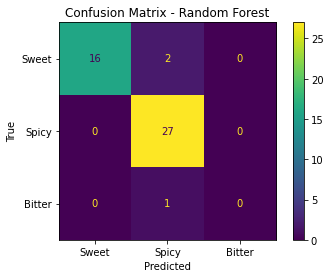

In [124]:
# Proper Confusion Matrix, Overall Accuracy, Kappa Coefficient

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
a = confusion_matrix(y1_test, y1_pred)
c1 = ConfusionMatrixDisplay(a, display_labels=['Sweet', 'Spicy', 'Bitter'])
c1.plot()
c1.ax_.set(xlabel='Predicted', ylabel='True', title = 'Confusion Matrix - Random Forest')

print('Overall Accuracy :', metrics.accuracy_score(y1_test, y1_pred))
print('Producer Accuracy(Recall) :', recall_score(y1_test, y1_pred, average='micro'))
print('User Accuracy (Precision) :', precision_score(y1_test, y1_pred, average='micro'))
print('Kappa Coefficient :', metrics.cohen_kappa_score(y1_test, y1_pred, labels=None, weights=None))

2. Support Vector Machines

In [105]:
# SVM - Gaussian Kernel

from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC



# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(x1_train, y1_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.611, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.611, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.611, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.583, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    1.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [106]:
grid.best_estimator_

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [107]:
# SVM - gaussian
from sklearn.svm import SVC
svclassifie = SVC(kernel='rbf', C=10, degree=3, gamma = 0.001)
svclassifie.fit(x1_train, y1_train)

y_1 = svclassifie.predict(x1_test)


In [108]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y1_test,y_1))
print(classification_report(y1_test,y_1))
print(f1_score(y1_test, y_1, average='micro'))

[[16  2  0]
 [ 0 27  0]
 [ 0  1  0]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.90      1.00      0.95        27
           2       0.00      0.00      0.00         1

    accuracy                           0.93        46
   macro avg       0.63      0.63      0.63        46
weighted avg       0.92      0.93      0.92        46

0.9347826086956522


Overall Accuracy : 0.9347826086956522
Producer Accuracy(Recall) : 0.9347826086956522
User Accuracy (Precision) : 0.9347826086956522
Kappa Coefficient : 0.8644400785854617


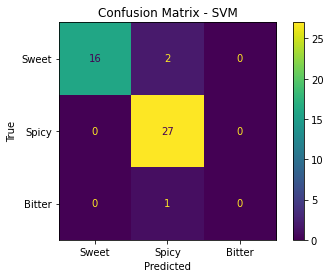

In [123]:
# Proper Confusion Matrix, Overall Accuracy, Kappa Coefficient

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
c1 = confusion_matrix(y1_test, y_1)
cd1 = ConfusionMatrixDisplay(c1, display_labels=['Sweet', 'Spicy', 'Bitter'])
cd1.plot()
cd1.ax_.set(xlabel='Predicted', ylabel='True', title = 'Confusion Matrix - SVM')

print('Overall Accuracy :', metrics.accuracy_score(y1_test, y_1))
print('Producer Accuracy(Recall) :', recall_score(y1_test, y_1, average='micro'))
print('User Accuracy (Precision) :', precision_score(y1_test, y_1, average='micro'))
print('Kappa Coefficient :', metrics.cohen_kappa_score(y1_test, y_1, labels=None, weights=None))

3. Xtreme Gradient Boosting - XGBOOST

In [110]:
import xgboost as xgb
modelxg1 = xgb.XGBClassifier(gamma = 0.001, learning_rate = 0.001, max_depth = 8, n_estimators = 100, random_state = 42, objective='reg:squarederror')
modelxg1.fit(x1_train,y1_train, eval_set=[(x1_train,y1_train)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.001,
              learning_rate=0.001, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [111]:
y1_xg = modelxg1.predict(x1_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y1_test,y1_xg))
print(classification_report(y1_test,y1_xg))
print(f1_score(y1_test, y1_xg, average='micro'))

[[16  2  0]
 [ 0 27  0]
 [ 0  1  0]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.90      1.00      0.95        27
           2       0.00      0.00      0.00         1

    accuracy                           0.93        46
   macro avg       0.63      0.63      0.63        46
weighted avg       0.92      0.93      0.92        46

0.9347826086956522


Overall Accuracy : 0.9347826086956522
Producer Accuracy(Recall) : 0.9347826086956522
User Accuracy (Precision) : 0.9347826086956522
Kappa Coefficient : 0.8644400785854617


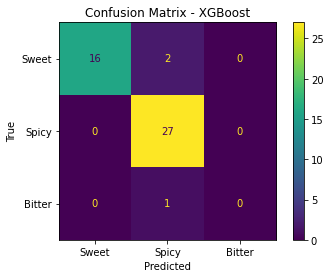

In [122]:
# Proper Confusion Matrix, Overall Accuracy, Kappa Coefficient

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
cm1 = confusion_matrix(y1_test, y1_xg)
cmd1 = ConfusionMatrixDisplay(cm1, display_labels=['Sweet', 'Spicy', 'Bitter'])
cmd1.plot()
cmd1.ax_.set(xlabel='Predicted', ylabel='True', title = 'Confusion Matrix - XGBoost')

print('Overall Accuracy :', metrics.accuracy_score(y1_test, y1_xg))
print('Producer Accuracy(Recall) :', recall_score(y1_test, y1_xg, average='micro'))
print('User Accuracy (Precision) :', precision_score(y1_test, y1_xg, average='micro'))
print('Kappa Coefficient :', metrics.cohen_kappa_score(y1_test, y1_xg, labels=None, weights=None))


# **Part - III : Visualisations**

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots

In [114]:
v = pd.read_csv('Data.csv')
v.head()

Name                                        Ingradients  \
0      Balu shahi                    Maida flour, yogurt, oil, sugar   
1          Boondi                            Gram flour, ghee, sugar   
2  Gajar ka halwa       Carrots, milk, sugar, ghee, cashews, raisins   
3          Ghevar  Flour, ghee, kewra, milk, clarified butter, su...   
4     Gulab jamun  Milk powder, plain flour, baking powder, ghee,...   

         Diet  Preparation Time  Cooking Time Flavor   Course        State  \
0  vegetarian              45.0          25.0  sweet  dessert  West Bengal   
1  vegetarian              80.0          30.0  sweet  dessert    Rajasthan   
2  vegetarian              15.0          60.0  sweet  dessert       Punjab   
3  vegetarian              15.0          30.0  sweet  dessert    Rajasthan   
4  vegetarian              15.0          40.0  sweet  dessert  West Bengal   

  Region  Price/unit  
0   East         260  
1   West         270  
2  North         450  
3   West         460  
4   East         300

In [115]:
pie_df = v.Diet.value_counts().reset_index()
pie_df.columns = ['Diet','count']
fig = px.pie(pie_df, values='count', names='Diet', title='%-Age of People with different Diets',
             color_discrete_sequence=['Blue', 'red'])
fig.show()

In [116]:
reg_df = v.Region.value_counts().reset_index()
reg_df.columns = ['region','count']
reg_df = reg_df.sample(frac=1)
fig = px.bar(reg_df,x='region',y='count',title='Number of dishes based on regions',
             color_discrete_sequence=['Orange'])
fig.show()

In [117]:
course_df = v.Course.value_counts().reset_index()
course_df.columns = ['course','count']
course_df = course_df.sample(frac=1)
fig = px.bar(course_df,x='course',y='count',title='Number of dishes based on courses of meal',
             color_discrete_sequence=['Blue'])
fig.show()

In [118]:
pie_df = v.Flavor.value_counts().reset_index()
pie_df.columns = ['flavor','count']
fig = px.pie(pie_df, values='count', names='flavor', title='Flavor Distribution among People',
             color_discrete_sequence=['#FF7F0E', '#00B5F7','#AB63FA','#00CC96'])
fig.show()

In [119]:
def state_infograph(statename, title) : 
    new_df = v[v['State']== statename]

    total_dishes = new_df.shape[0]

    course_df = new_df['Course'].value_counts().reset_index()
    course_df.columns = ['Course','num']

    diet_df = new_df['Diet'].value_counts().reset_index()
    diet_df.columns = ['Diet','num']
    
#     flavor_df = new_df['prep_time'].value_counts().reset_index()
#     flavor_df.columns = ['Flavor','num']

    prep_time_df = new_df['Preparation Time'].value_counts().reset_index()
    prep_time_df.columns = ['Preparation Time', 'num']

    fig = make_subplots(
        rows=2, cols=3,subplot_titles=('Total Dishes','Dishes by Courses','              Dishes by Preparation time', '',''),
        specs=[[{'type': 'indicator'},{'type': 'bar','rowspan': 2},{'type': 'bar','rowspan': 2}],
              [ {'type': 'pie'} , {'type': 'pie'}, {'type': 'pie'}]])

    fig.add_trace(go.Indicator(
        mode = 'number',
        value = int(total_dishes),
        number={'font':{'color': '#270082','size':50}},
    ),row=1, col=1)


    fig.add_trace(go.Bar(x=course_df['Course'],y=course_df['num'], marker={'color': 'blue'}, 
                         text=course_df['num'],name='dishes by courses',textposition ='auto'),row=1, col=2)

    fig.add_trace(go.Pie(labels=diet_df['Diet'], values=diet_df['num'],textinfo='percent',
                         marker= dict(colors=['#00bd0d','#fc0303'])),row=2, col=1)

    fig.add_trace(go.Bar(
        x=prep_time_df['Preparation Time'],y=course_df['num'],marker={'color': '#fc0335'}, text=course_df['num'],
        name='flavors by courses',textposition ='auto'),row=1, col=3)

    fig.update_layout(title_text= title,template='plotly',title_x=0.5)

    return fig.show()

In [120]:
state_infograph('West Bengal', 'West Bengal food infograph')

In [121]:
state_infograph('Punjab', 'Punjab food infograph')